In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

## 1. Структура данных

In [2]:
data = pd.read_csv(
    "./data/data.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
#Анализ номеров счетов (InvoiceNo)
print('Уникальные префиксы в InvoiceNo:')
invoice_prefixes = data['InvoiceNo'].str.extract(r'^(\D+)', expand=False).dropna().unique()
print(f'Найдены префиксы: {invoice_prefixes}')
#Разделение на обычные транзакции и возвраты
data['Is_Cancellation'] = data['InvoiceNo'].str.startswith('C')
data['Is_Discount'] = data['StockCode'].str.contains('D|POST|M', case=False, na=False)
print(f'\nКоличество транзакций с возвратами: {data["Is_Cancellation"].sum()}')
print(f'Количество транзакций со скидками: {data["Is_Discount"].sum()}')

Уникальные префиксы в InvoiceNo:
Найдены префиксы: ['C' 'A']

Количество транзакций с возвратами: 9288
Количество транзакций со скидками: 6957


In [4]:
#Анализ Quantity с разделением на покупки и возвраты
print('Анализ Quantity:')
print('Все транзакции:')
print(f'  Диапазон: [{data["Quantity"].min()} - {data["Quantity"].max()}]')
print(f'  Среднее: {data["Quantity"].mean():.2f}')
print(f'  Медиана: {data["Quantity"].median()}')
print('\nТолько покупки (Quantity > 0):')
purchases = data[data['Quantity'] > 0]
print(f'  Диапазон: [{purchases["Quantity"].min()} - {purchases["Quantity"].max()}]')
print(f'  Среднее: {purchases["Quantity"].mean():.2f}')
print(f'  Медиана: {purchases["Quantity"].median()}')
print('\nТолько возвраты (Quantity < 0):')
returns = data[data['Quantity'] < 0]
print(f'  Диапазон: [{returns["Quantity"].min()} - {returns["Quantity"].max()}]')
print(f'  Среднее: {returns["Quantity"].mean():.2f}')
print(f'  Медиана: {returns["Quantity"].median()}')

Анализ Quantity:
Все транзакции:
  Диапазон: [-80995 - 80995]
  Среднее: 9.55
  Медиана: 3.0

Только покупки (Quantity > 0):
  Диапазон: [1 - 80995]
  Среднее: 10.66
  Медиана: 3.0

Только возвраты (Quantity < 0):
  Диапазон: [-80995 - -1]
  Среднее: -45.61
  Медиана: -2.0


In [5]:
#Анализ UnitPrice
print('\nАнализ UnitPrice:')
print(f'Диапазон: [{data["UnitPrice"].min():.2f} - {data["UnitPrice"].max():.2f}] ₤')
print(f'Среднее: {data["UnitPrice"].mean():.2f} ₤')
print(f'Медиана: {data["UnitPrice"].median():.2f} ₤')
print(f'Количество бесплатных товаров (UnitPrice = 0): {(data["UnitPrice"] == 0).sum()}')


Анализ UnitPrice:
Диапазон: [-11062.06 - 38970.00] ₤
Среднее: 4.61 ₤
Медиана: 2.08 ₤
Количество бесплатных товаров (UnitPrice = 0): 2515


In [6]:
#Уникальные клиенты (исключая пропуски)
valid_customers = data[data['CustomerID'].notna()]
unique_customers = valid_customers['CustomerID'].nunique()
print(f'Количество уникальных клиентов: {unique_customers}')
#Анализ активности клиентов
customer_stats = valid_customers['CustomerID'].value_counts()
print(f'\nСтатистика по транзакциям на клиента:')
print(f'Минимальное количество транзакций: {customer_stats.min()}')
print(f'Максимальное количество транзакций: {customer_stats.max()}')
print(f'Среднее количество транзакций: {customer_stats.mean():.2f}')
print(f'Медианное количество транзакций: {customer_stats.median()}')

Количество уникальных клиентов: 4372

Статистика по транзакциям на клиента:
Минимальное количество транзакций: 1
Максимальное количество транзакций: 7983
Среднее количество транзакций: 93.05
Медианное количество транзакций: 42.0


Количество уникальных стран: 38


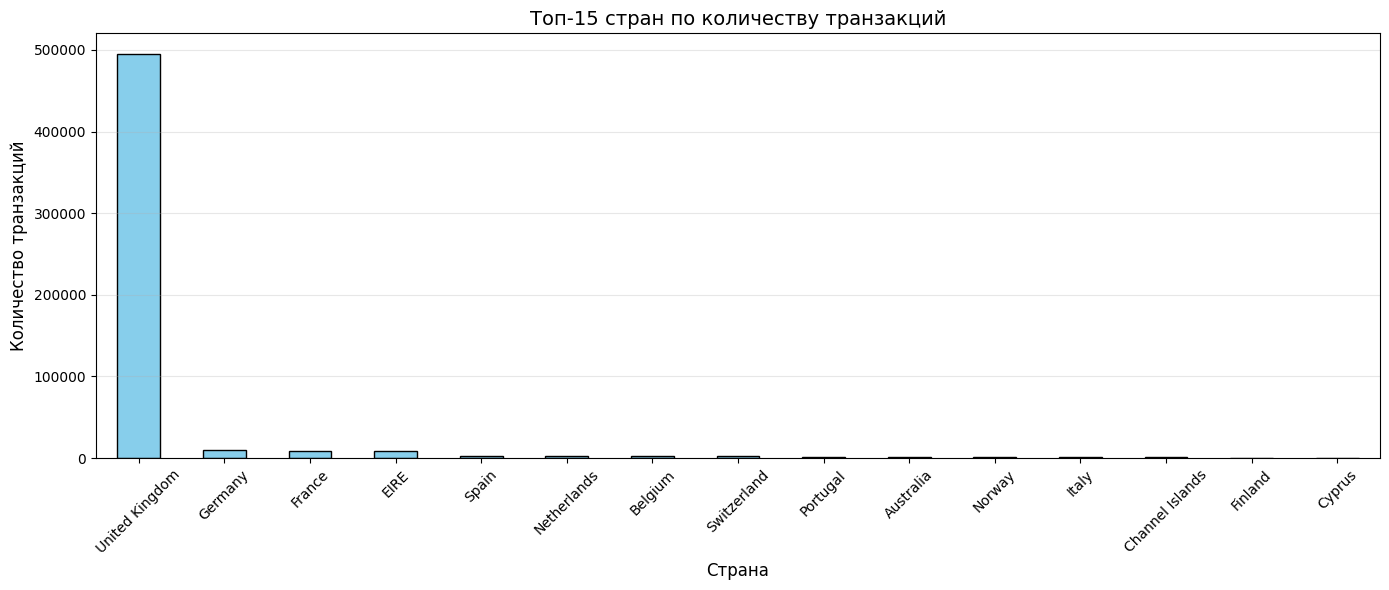

In [7]:
#Уникальные страны
unique_countries = data['Country'].nunique()
print(f'Количество уникальных стран: {unique_countries}')
#Количество транзакций
country_stats = data['Country'].value_counts()
#Визуализация распределения по странам
plt.figure(figsize=(14, 6))
country_stats.head(15).plot(kind='bar', color='skyblue')
plt.title('Топ-15 стран по количеству транзакций', fontsize=14)
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
#Проверка пропусков
print('Пропущенные значения по столбцам:')
missing_values = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percentage.round(2)
})
print(missing_info[missing_info['Количество пропусков'] > 0])
#Анализ пропусков в CustomerID
missing_customers = data[data['CustomerID'].isna()]
print(f'\nТранзакции без CustomerID: {len(missing_customers)}')
print('Распределение по странам для транзакций без CustomerID:')
print(missing_customers['Country'].value_counts().head(10))

Пропущенные значения по столбцам:
             Количество пропусков  Процент пропусков
Description                  1454               0.27
CustomerID                 135080              24.93

Транзакции без CustomerID: 135080
Распределение по странам для транзакций без CustomerID:
Country
United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: count, dtype: int64


In [10]:
#Проверка дубликатов
total_duplicates = data.duplicated().sum()
print(f'\nОбщее количество полных дубликатов строк: {total_duplicates}')


Общее количество полных дубликатов строк: 5268


In [11]:
#Преобразование даты в datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print(f'Диапазон дат транзакций: от {data["InvoiceDate"].min()} до {data["InvoiceDate"].max()}')
#Дополнительный временной анализ
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['Weekday'] = data['InvoiceDate'].dt.weekday
data['Hour'] = data['InvoiceDate'].dt.hour
print(f'\nГоды в данных: {sorted(data["Year"].unique())}')
print(f'Месяцы в данных: {sorted(data["Month"].unique())}')

Диапазон дат транзакций: от 2010-12-01 08:26:00 до 2011-12-09 12:50:00

Годы в данных: [np.int32(2010), np.int32(2011)]
Месяцы в данных: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]
